In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_train_lr= pd.read_csv('./X_train_all_feature.csv',index_col=0)
y_train= pd.read_csv('./y_train_all_feature.csv')
X_test_lr= pd.read_csv('./X_test_all_feature.csv', index_col=0)
y_test= pd.read_csv('./y_test_all_feature.csv')
X_test_lr.fillna(0,inplace=True)

In [8]:
importances=['TotalTeDiagCode',
 'TotalInscClaimAmtReimbursed',
 'MaxProcCodeNumPerClaim',
 'MaxHospitalDays',
 'TotalTeProcCode',
 'totalDiagCode_25000',
 'OPAnnualReimbursementAmt_sum',
 'totalDiagCode_496',
 'totalDiagCode_41400',
 'totalDiagCode_4019']
X_train_rf=pd.DataFrame(X_train_lr,columns=importances)
X_test_rf=pd.DataFrame(X_test_lr,columns=importances)

In [9]:

import joblib
model_lr = joblib.load('logreg_model_balanced.sav')
model_rf = joblib.load('rf_model.sav')

In [10]:
model_lr 

Pipeline(steps=[('rescale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='newton-cg'))])

In [11]:
model_rf

Pipeline(steps=[('Rescale', MinMaxScaler()),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=15,
                                        min_samples_leaf=5,
                                        min_samples_split=50, n_estimators=15,
                                        oob_score=True, random_state=0))])

random forest       0.758
logistic regression 0.915


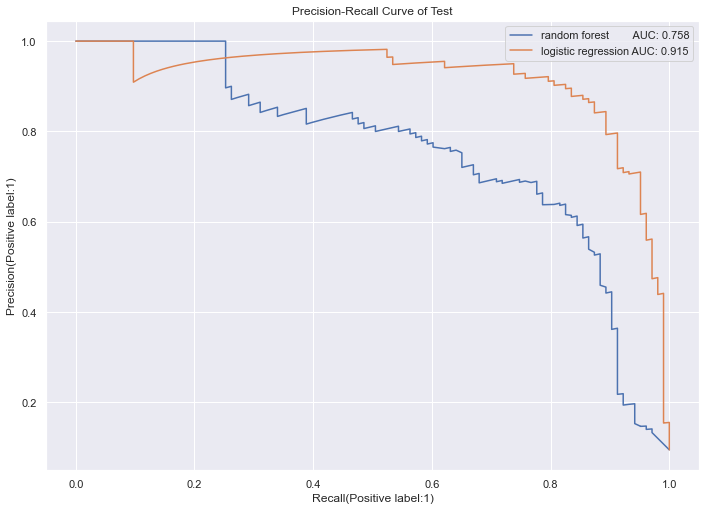

In [12]:

from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc,plot_precision_recall_curve
sns.set(rc={'figure.figsize':(11.7,8.27)})

y_test_proba_rf = model_rf.predict_proba(X_test_rf)
y_test_score_rf = y_test_proba_rf[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_test_score_rf)
auc_precision_recall_rf = auc(recall_rf, precision_rf)

y_test_proba_lr = model_lr.predict_proba(X_test_lr)
y_test_score_lr = y_test_proba_lr[:, 1]
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_test_score_lr)
auc_precision_recall_lr = auc(recall_lr, precision_lr)



print('random forest      ','{:.3f}'.format(auc_precision_recall_rf))
print('logistic regression','{:.3f}'.format(auc_precision_recall_lr))

plt.plot(recall_rf, precision_rf,
         label='random forest        AUC: '+str(round(auc_precision_recall_rf,3)))
plt.plot(recall_lr, precision_lr,
         label='logistic regression AUC: '+str(round(auc_precision_recall_lr,3)))
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve'+' of '+'Test')
plt.legend()
plt.show()

In [13]:
average_precision_rf = average_precision_score(y_test, y_test_score_rf)
average_precision_lr = average_precision_score(y_test, y_test_score_lr)

# calibrate

In [14]:

y_test_pred_lr = model_lr.predict(X_test_lr)
print('original test Fraud percentage: ',np.count_nonzero(y_test==1)/y_test.size)
print('predict test Fraud percentage:  ',np.count_nonzero(y_test_pred_lr ==1)/y_test.size)


original test Fraud percentage:  0.09519408502772643
predict test Fraud percentage:   0.011090573012939002


In [15]:

y_test_pred_rf = model_rf.predict(X_test_rf)
print('original test Fraud percentage: ',np.count_nonzero(y_test==1)/y_test.size)
print('predict test Fraud percentage:  ',np.count_nonzero(y_test_pred_rf ==1)/y_test.size)

original test Fraud percentage:  0.09519408502772643
predict test Fraud percentage:   0.038817005545286505


In [16]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
rf=CalibratedClassifierCV(model_rf[1][1], method='isotonic')
lr=CalibratedClassifierCV(model_lr[1], method='isotonic')
rf.fit(X_train_rf,y_train)
lr.fit(X_train_lr,y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                         class_weight='balanced',
                                                         max_iter=10000,
                                                         random_state=42,
                                                         solver='newton-cg'),
                       method='isotonic')

In [17]:

y_test_proba_lr = lr.predict_proba(X_test_lr)
y_test_proba_rf = rf.predict_proba(X_test_rf)

In [18]:

fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_test, y_test_proba_rf [:,1], n_bins=10)
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, y_test_proba_lr [:,1], n_bins=10)

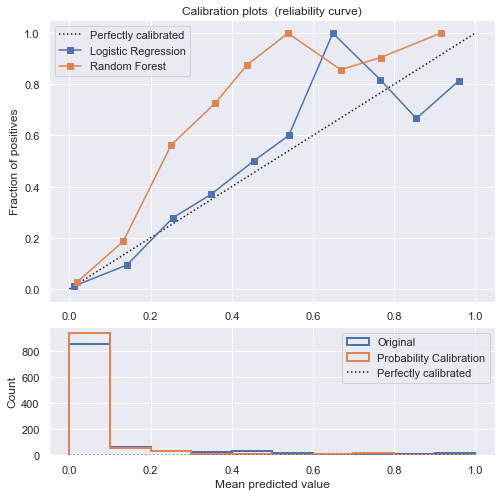

In [20]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-",label="%s" % ('Logistic Regression', ))
ax1.plot(mean_predicted_value_rf, fraction_of_positives_rf, "s-",label="%s" % ('Random Forest', ))
ax2.hist(y_test_proba_lr [:,1], range=(0, 1), bins=10, label='Original',
             histtype="step", lw=2)
ax2.hist(y_test_proba_rf [:,1], range=(0, 1), bins=10, label='Probability Calibration',
             histtype="step", lw=2)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.set_ylabel("Fraction of positives")
ax1.set_title('Calibration plots  (reliability curve)')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax1.legend()
ax2.legend()
plt.show()

In [22]:
from sklearn.metrics import brier_score_loss
y_test_proba_lr = lr.predict_proba(X_test_lr)
print('lr brier_score is : ', brier_score_loss(y_test, y_test_proba_lr[:,1]))

y_test_pred_lr = lr.predict(X_test_lr)
print('original test Fraud percentage: ',np.count_nonzero(y_test==1)/y_test.size)
print('predict test Fraud percentage:  ',np.count_nonzero(y_test_pred_lr ==1)/y_test.size)

lr brier_score is :  0.046319878667406306
original test Fraud percentage:  0.09519408502772643
predict test Fraud percentage:   0.06284658040665435


In [23]:
from sklearn.metrics import brier_score_loss
y_test_proba_rf = rf.predict_proba(X_test_rf)
print('rf brier_score is : ', brier_score_loss(y_test, y_test_proba_rf[:,1]))

y_test_pred_rf = rf.predict(X_test_rf)
print('original test Fraud percentage: ',np.count_nonzero(y_test==1)/y_test.size)
print('predict test Fraud percentage:  ',np.count_nonzero(y_test_pred_rf ==1)/y_test.size)

rf brier_score is :  0.050800644004278826
original test Fraud percentage:  0.09519408502772643
predict test Fraud percentage:   0.033271719038817
